In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In [208]:
model = pd.read_csv('model_data.csv')

model.drop('Unnamed: 0',axis=1,inplace=True)

model.head()

<AxesSubplot:xlabel='Age'>

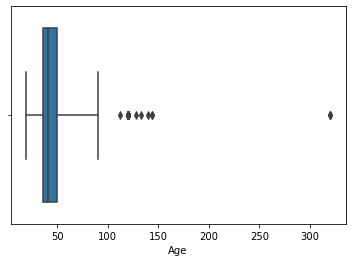

In [211]:
sns.boxplot(model['Age'],whis=3)

In [212]:
import scipy.stats as st

iqr = st.iqr(model['Age'])
q1 = model['Age'].quantile(0.25)
q3 = model['Age'].quantile(0.75)

ll = q1 - (3*(iqr))
ul = q3 + (3*iqr)

model1 = model[(model['Age']>ll)&(model['Age']<ul)]

data = model1.copy()

from sklearn.preprocessing import LabelEncoder
l1_car_cat = LabelEncoder()
l2_subject_car = LabelEncoder()
l3_product_name = LabelEncoder()

data['Car_Category'] = l1_car_cat.fit_transform(data['Car_Category'])
#data['Subject_Car_Make'] = l2_subject_car.fit_transform(data['Subject_Car_Make'])
data['ProductName'] = l3_product_name.fit_transform(data['ProductName'])

data.head()

In [219]:
x = data[['Age','No_Pol','ProductName','days','Male','others']]
y = data['Subject_Car_Make']

In [220]:
from xgboost import XGBClassifier
xg_sub = XGBClassifier()
xg_sub.fit(x,y)

[21:39:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [221]:
df = pd.read_csv('testing_modified.csv')
df.head()

,Unnamed: 0,ID,Gender,Age,No_Pol,Car_Category,Subject_Car_Make,ProductName,days
0,0,ID_01QM0NU,Female,46,1,NaN,Ford,Car Classic,364
1,1,ID_024NJLZ,Male,32,1,NaN,NaN,Car Classic,364
2,2,ID_02NOVWQ,Female,45,2,Saloon,Honda,Car Classic,364
3,3,ID_02VSP68,Female,58,1,Saloon,TOYOTA,CarSafe,364
4,4,ID_02YB37K,NaN,120,1,Saloon,Hyundai,Car Classic,364


In [222]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [223]:
df_gen = pd.get_dummies(df['Gender'],drop_first=True)

In [224]:
test = df.join(df_gen)

In [225]:
test.head()

,ID,Gender,Age,No_Pol,Car_Category,Subject_Car_Make,ProductName,days,Male,others
0,ID_01QM0NU,Female,46,1,NaN,Ford,Car Classic,364,0,0
1,ID_024NJLZ,Male,32,1,NaN,NaN,Car Classic,364,1,0
2,ID_02NOVWQ,Female,45,2,Saloon,Honda,Car Classic,364,0,0
3,ID_02VSP68,Female,58,1,Saloon,TOYOTA,CarSafe,364,0,0
4,ID_02YB37K,NaN,120,1,Saloon,Hyundai,Car Classic,364,0,0


In [226]:
test.drop(['Gender','Car_Category'],axis=1,inplace=True)

In [227]:
def fun(x):
    if x<ll:
        return np.nan
    elif x>ul:
        return np.nan
    else:
        return x

In [228]:
test['Age']=test['Age'].apply(fun)

In [229]:
test.isnull().sum()

ID                    0
Age                  45
No_Pol                0
Subject_Car_Make    248
ProductName           0
days                  0
Male                  0
others                0
dtype: int64

In [230]:
test['ProductName']  = l3_product_name.transform(test['ProductName'])

In [231]:
test['Age'].fillna(value=data['Age'].median(),inplace=True)

In [232]:
test_sub = test[test['Subject_Car_Make'].isnull()==True]
test_sub2 = test[test['Subject_Car_Make'].isnull()==False]


In [233]:
test_sub.head()

,ID,Age,No_Pol,Subject_Car_Make,ProductName,days,Male,others
1,ID_024NJLZ,32.0,1,NaN,1,364,1,0
9,ID_0CRE393,38.0,3,NaN,1,364,1,0
13,ID_0G32KK0,36.0,1,NaN,1,363,1,0
14,ID_0G8LN29,7.0,1,NaN,1,364,0,0
25,ID_0P00KVT,39.0,1,NaN,5,364,1,0


In [234]:
xtest = test_sub.drop(['ID','Subject_Car_Make'],axis=1)

In [235]:
xtest.head()

,Age,No_Pol,ProductName,days,Male,others
1,32.0,1,1,364,1,0
9,38.0,3,1,364,1,0
13,36.0,1,1,363,1,0
14,7.0,1,1,364,0,0
25,39.0,1,5,364,1,0


In [177]:
'Age','No_Pol','ProductName','days','Male','others'

('Age', 'No_Pol', 'ProductName', 'days', 'Male', 'others')

In [236]:
test_sub.drop('Subject_Car_Make',axis=1,inplace=True)

In [237]:
test_sub['Subject_Car_Make'] = xg_sub.predict(xtest)

In [238]:
test_sub

,ID,Age,No_Pol,ProductName,days,Male,others,Subject_Car_Make
1,ID_024NJLZ,32.0,1,1,364,1,0,TOYOTA
9,ID_0CRE393,38.0,3,1,364,1,0,TOYOTA
13,ID_0G32KK0,36.0,1,1,363,1,0,TOYOTA
14,ID_0G8LN29,7.0,1,1,364,0,0,TOYOTA
25,ID_0P00KVT,39.0,1,5,364,1,0,TOYOTA
...,...,...,...,...,...,...,...,...
1168,ID_YRA2RK6,46.0,1,5,364,1,0,TOYOTA
1173,ID_YVBCOPX,64.0,1,1,364,0,0,TOYOTA
1177,ID_Z3M4DFB,39.0,1,5,364,0,0,TOYOTA
1186,ID_ZIETYEH,51.0,1,1,364,1,0,TOYOTA


In [239]:
test_sub2

,ID,Age,No_Pol,Subject_Car_Make,ProductName,days,Male,others
0,ID_01QM0NU,46.0,1,Ford,1,364,0,0
2,ID_02NOVWQ,45.0,2,Honda,1,364,0,0
3,ID_02VSP68,58.0,1,TOYOTA,5,364,0,0
4,ID_02YB37K,41.0,1,Hyundai,1,364,0,0
5,ID_04OFD80,64.0,2,TOYOTA,1,276,1,0
...,...,...,...,...,...,...,...,...
1197,ID_ZTTHC5X,67.0,2,TOYOTA,1,364,1,0
1198,ID_ZUJAFUP,43.0,1,Hyundai,1,364,1,0
1199,ID_ZWHCTUM,30.0,1,Iveco,0,364,1,0
1200,ID_ZWQRL8L,44.0,2,Nissan,1,364,1,0


In [240]:
new = pd.concat([test_sub2,test_sub])

In [242]:
final_test = new.sort_index()

In [247]:
final_test['Car_Category'] = test_new['Car_Category']

In [249]:
final_test.to_csv('only_car_cat.csv')

In [245]:
test_new = pd.read_csv('testing_modified.csv')

In [246]:
test_new

,Unnamed: 0,ID,Gender,Age,No_Pol,Car_Category,Subject_Car_Make,ProductName,days
0,0,ID_01QM0NU,Female,46,1,NaN,Ford,Car Classic,364
1,1,ID_024NJLZ,Male,32,1,NaN,NaN,Car Classic,364
2,2,ID_02NOVWQ,Female,45,2,Saloon,Honda,Car Classic,364
3,3,ID_02VSP68,Female,58,1,Saloon,TOYOTA,CarSafe,364
4,4,ID_02YB37K,NaN,120,1,Saloon,Hyundai,Car Classic,364
...,...,...,...,...,...,...,...,...,...
1197,1197,ID_ZTTHC5X,Male,67,2,JEEP,TOYOTA,Car Classic,364
1198,1198,ID_ZUJAFUP,Male,43,1,Saloon,Hyundai,Car Classic,364
1199,1199,ID_ZWHCTUM,Male,30,1,Truck,Iveco,CVTP,364
1200,1200,ID_ZWQRL8L,Male,44,2,Saloon,Nissan,Car Classic,364


In [250]:
final_test

,ID,Age,No_Pol,Subject_Car_Make,ProductName,days,Male,others,Car_Category
0,ID_01QM0NU,46.0,1,Ford,1,364,0,0,NaN
1,ID_024NJLZ,32.0,1,TOYOTA,1,364,1,0,NaN
2,ID_02NOVWQ,45.0,2,Honda,1,364,0,0,Saloon
3,ID_02VSP68,58.0,1,TOYOTA,5,364,0,0,Saloon
4,ID_02YB37K,41.0,1,Hyundai,1,364,0,0,Saloon
...,...,...,...,...,...,...,...,...,...
1197,ID_ZTTHC5X,67.0,2,TOYOTA,1,364,1,0,JEEP
1198,ID_ZUJAFUP,43.0,1,Hyundai,1,364,1,0,Saloon
1199,ID_ZWHCTUM,30.0,1,Iveco,0,364,1,0,Truck
1200,ID_ZWQRL8L,44.0,2,Nissan,1,364,1,0,Saloon
